### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:

- just use async langchain, support google vs openai vs anthropic transparently
- use exponential backoff to deal with rate limit issues (using metadata is not really well supported across llm providers, openai only gives time to reset in the http headers and not in the API itelf)
- do tests with promptfoo, promptlayer, do prompt optimization with eg dspy or your own thing
- scrape, extract, filter headlines, download pages, summarize, filter, categorize and sort, compose, rewrite


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
del sys.modules['AInewsbot_langgraph']



KeyError: 'AInewsbot_langgraph'

In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (newscatcher_sources, fn_initialize, fn_download_sources, fn_extract_urls,
                                 fn_verify_download, fn_extract_newscatcher, fn_extract_newsapi,
                                 fn_filter_urls, fn_topic_clusters, fn_topic_analysis, fn_download_pages, 
                                 fn_summarize_pages, fn_propose_cats,
                                 fn_compose_summary, fn_rewrite_summary, fn_is_revision_complete, fn_send_mail
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:21:42) [Clang 18.1.8 ]
LangChain         0.3.18
OpenAI            1.63.1
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Define LangGraph agent state graph

In [4]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [5]:
# sqlite schema to store previously processed headlines
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [6]:
# some debugging stuff, check a headline is cached properly
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")]
# xdf.loc[xdf["title"].str.startswith("NHTSA")]

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [7]:
class Agent:

    def __init__(self, state):

        self.state = state

        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("verify_download", self.verify_download)
        graph_builder.add_node("extract_newsapi_urls",
                               self.extract_newsapi_urls)
        # graph_builder.add_node("extract_newscatcher_urls",
        #                        self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "verify_download")
        graph_builder.add_edge("verify_download", "extract_newsapi_urls")
        graph_builder.add_edge("extract_newsapi_urls", "filter_urls")
        # graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                             })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories
        # self.conn = sqlite3.connect('lg_checkpointer.db')
        # self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,)
#                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def verify_download(self, state: AgentState) -> AgentState:
        self.state = fn_verify_download(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        try:
            self.state = fn_extract_newscatcher(state)
        except KeyError:
            log("Newscatcher download failed")
        return self.state

    def extract_newsapi_urls(self, state: AgentState) -> AgentState:
        try:
            self.state = fn_extract_newsapi(state)
        except KeyError:
            log("NewsAPI download failed")
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values")
        for event in events:
            try:
                if event.get('summary'):
                    print('summary created')
                    display(event.get('summary').replace("$", "\\\\$"))
                elif event.get('bullets'):
                    print('bullets created')
                    display("\n\n".join(
                        event.get('bullets')).replace("$", "\\\\$"))
                elif event.get('cluster_topics'):
                    print('cluster topics created')
                    display("\n\n".join(event.get('cluster_topics')))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby(
                        "src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc:
                print('run exception')
                print(exc)

        return self.state



In [8]:
def initialize_agent(do_download, before_date):
    # initial state
    state = AgentState({
        'AIdf': [{}],
        'before_date': before_date,
        'do_download': do_download,
        'sources': {},
        'sources_reverse': {},
        'bullets': '',
        'summary': '',
        'cluster_topics': [],
        'topics_str': '',
        'n_edits': 0,
        'edit_complete': False,
    })
    global thread_id
    thread_id = uuid.uuid4().hex
    log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}"
        )
    return state, Agent(state), thread_id


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
before_date = None
before_date = '2025-02-18 18:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


In [ ]:
AIdf

In [ ]:
process dataframe - take id column
verify all ids passed returned
exception if not returned

In [ ]:
# it will stop if check sources not passed
# or if we force a stop compiling with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)

aidf = pd.DataFrame(last_state.values["AIdf"])
aidf['id'].to_list()


In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-02-19 19:14:45,729 - AInewsbot - INFO - Initializing with before_date=2025-02-19 08:00, do_download=False, thread_id=b85214f6a0cd45e996fc0dc62bf31740


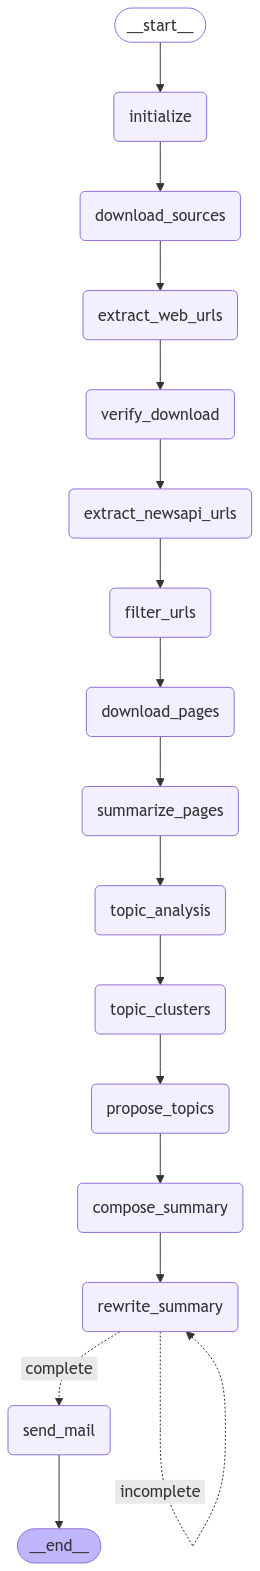

In [9]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-02-19 08:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [10]:
state = lg_agent.initialize(state)


2025-02-19 19:14:49,993 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-02-19 19:14:49,994 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2025-02-19 19:14:49,995 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2025-02-19 19:14:49,995 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2025-02-19 19:14:49,995 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2025-02-19 19:14:49,996 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-02-19 19:14:49,996 - AInewsbot - INFO - 

In [11]:
state = lg_agent.download_sources(state)


2025-02-19 19:14:50,181 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-02-19 19:14:50,187 - AInewsbot - INFO - Found 16 previously downloaded files
2025-02-19 19:14:50,188 - AInewsbot - INFO - htmldata/Hacker News Page 1 (02_19_2025 06_02_08 PM).html
2025-02-19 19:14:50,188 - AInewsbot - INFO - htmldata/FT Technology (02_19_2025 06_01_58 PM).html
2025-02-19 19:14:50,189 - AInewsbot - INFO - htmldata/Techmeme (02_19_2025 06_02_25 PM).html
2025-02-19 19:14:50,189 - AInewsbot - INFO - htmldata/The Verge AI (02_19_2025 06_02_37 PM).html
2025-02-19 19:14:50,189 - AInewsbot - INFO - htmldata/Ars Technica (02_19_2025 06_01_58 PM).html
2025-02-19 19:14:50,190 - AInewsbot - INFO - htmldata/Washington Post Technology (02_19_2025 06_02_56 PM).html
2025-02-19 19:14:50,190 - AInewsbot - INFO - htmldata/Business Insider Tech (02_19_2025 06_01_56 PM).html
2025-02-19 19:14:50,190 - AInewsbot - INFO - htmldata/Feedly AI (02_19_2025 06_03_17 PM).html
2025-02-19 19:14:50,1

In [12]:
state = lg_agent.extract_web_urls(state)


2025-02-19 19:15:04,681 - AInewsbot - INFO - Parsing html files
2025-02-19 19:15:04,683 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (02_19_2025 06_01_58 PM).html
2025-02-19 19:15:04,746 - AInewsbot - INFO - parse_file - found 203 raw links
2025-02-19 19:15:04,750 - AInewsbot - INFO - parse_file - found 39 filtered links
2025-02-19 19:15:04,750 - AInewsbot - INFO - 39 links found
2025-02-19 19:15:04,750 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (02_19_2025 06_02_03 PM).html
2025-02-19 19:15:04,777 - AInewsbot - INFO - parse_file - found 204 raw links
2025-02-19 19:15:04,781 - AInewsbot - INFO - parse_file - found 15 filtered links
2025-02-19 19:15:04,782 - AInewsbot - INFO - 15 links found
2025-02-19 19:15:04,783 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (02_19_2025 06_01_56 PM).html
2025-02-19 19:15:04,817 - AInewsbot - INFO - parse_file - found 207 raw links
2025-02-19 19:15:04,823 - AInewsbot - INFO - parse_file 

In [13]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(state["sources"].keys()) - set(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,31
Bloomberg Tech,12
Business Insider,21
FT Tech,62
Feedly AI,36
Hacker News,28
Hacker News 2,23
HackerNoon,99
NYT Tech,19


number of missing sources 0


set()

In [14]:
state = lg_agent.verify_download(state)


2025-02-19 19:15:32,353 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [15]:
state = lg_agent.extract_newsapi_urls(state)


2025-02-19 19:15:35,873 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-02-18T19:15:35 from NewsAPI


In [16]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
state = lg_agent.filter_urls(state)
display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])


2025-02-19 19:15:37,696 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-02-19 08:00'
2025-02-19 19:15:38,229 - AInewsbot - INFO - URLs in orig_df: 935
2025-02-19 19:15:38,232 - AInewsbot - INFO - Existing URLs in DB: 219013
2025-02-19 19:15:38,287 - AInewsbot - INFO - New URLs in df filtered by URL: 361
2025-02-19 19:15:38,401 - AInewsbot - INFO - Existing src+title: 3
2025-02-19 19:15:38,402 - AInewsbot - INFO - New URLs in df filtered by src+title: 358
2025-02-19 19:15:38,414 - AInewsbot - INFO - Found 358 unique new headlines
2025-02-19 19:15:38,417 - AInewsbot - INFO - Found 357 unique new headlines
2025-02-19 19:15:40,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:15:44,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:15:47,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 20

,id
src,
Ars Technica,4
Bloomberg Tech,1
Business Insider,4
FT Tech,2
Feedly AI,29
Hacker News,3
HackerNoon,2
NYT Tech,2
NewsAPI,36


2025-02-19 19:16:21,773 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 95132
2025-02-19 19:16:21,773 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 95132
2025-02-19 19:16:21,774 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 95132
2025-02-19 19:16:21,774 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 95132
2025-02-19 19:16:41,184 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-19 19:16:41,185 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-19 19:16:41,185 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-19 19:16:41,187 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-02-19 19:16:41,187 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-19 19:16:41,188 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-19 19:16:41,188 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-02-19 19:16

In [17]:
state = lg_agent.download_pages(state)


2025-02-19 19:16:21,748 - AInewsbot - INFO - Queuing URLs for scraping
2025-02-19 19:17:30,676 - AInewsbot - INFO - Processing page 0: https://tech.co/news/fiverr-go-freelancers-ai
2025-02-19 19:17:30,682 - AInewsbot - INFO - Processing page 1: https://venturebeat.com/security/a-stytch-in-time-connected-apps-untangles-authorization-tie-ups-for-ai-agents/
2025-02-19 19:17:30,682 - AInewsbot - INFO - Processing page 2: https://www.businessinsider.com/unstructured-data-extraction-startup-pulse-funding-nat-friedman-daniel-gross-2025-2
2025-02-19 19:17:30,682 - AInewsbot - INFO - Processing page 3: https://hackernoon.com/ai-can-outsmart-you-and-cybercriminals-know-it
2025-02-19 19:17:30,683 - AInewsbot - INFO - get_url(https://tech.co/news/fiverr-go-freelancers-ai) - starting get_url https://tech.co/news/fiverr-go-freelancers-ai
2025-02-19 19:17:30,683 - AInewsbot - INFO - get_url(https://venturebeat.com/security/a-stytch-in-time-connected-apps-untangles-authorization-tie-ups-for-ai-agents/

2025-02-19 19:17:31,280 - AInewsbot - INFO - get_url(https://www.businessinsider.com/apple-iphone-16e-brings-ai-to-more-sales-boost-2025-2) - starting get_url https://www.businessinsider.com/apple-iphone-16e-brings-ai-to-more-sales-boost-2025-2
2025-02-19 19:17:31,281 - AInewsbot - INFO - Processing page 20: https://www.telkins.dev/blog/how-apples-closed-source-approach-is-losing-out-to-ai-app-builders
2025-02-19 19:17:31,281 - AInewsbot - INFO - get_url(https://www.telkins.dev/blog/how-apples-closed-source-approach-is-losing-out-to-ai-app-builders) - starting get_url https://www.telkins.dev/blog/how-apples-closed-source-approach-is-losing-out-to-ai-app-builders
2025-02-19 19:17:31,281 - AInewsbot - INFO - Processing page 21: https://www.sciencedaily.com/releases/2025/02/250218150106.htm
2025-02-19 19:17:31,282 - AInewsbot - INFO - get_url(https://www.sciencedaily.com/releases/2025/02/250218150106.htm) - starting get_url https://www.sciencedaily.com/releases/2025/02/250218150106.htm
20

2025-02-19 19:17:37,443 - AInewsbot - INFO - Error processing https://www.entrepreneur.com/science-technology/chatgpt-isnt-cutting-it-for-busy-professionals-anymore/486804, continuing...
2025-02-19 19:17:37,444 - AInewsbot - INFO - Processing page 36: https://www.bankingdive.com/news/fed-barr-genai-risks-banking-fintech-nonbanks/740387/
2025-02-19 19:17:37,444 - AInewsbot - INFO - get_url(https://www.bankingdive.com/news/fed-barr-genai-risks-banking-fintech-nonbanks/740387/) - starting get_url https://www.bankingdive.com/news/fed-barr-genai-risks-banking-fintech-nonbanks/740387/
2025-02-19 19:17:37,445 - AInewsbot - INFO - Processing page 37: https://www.pymnts.com/google/2025/google-makes-visual-search-tool-available-for-iphones/
2025-02-19 19:17:37,446 - AInewsbot - INFO - get_url(https://www.pymnts.com/google/2025/google-makes-visual-search-tool-available-for-iphones/) - starting get_url https://www.pymnts.com/google/2025/google-makes-visual-search-tool-available-for-iphones/
2025-0

2025-02-19 19:17:43,073 - AInewsbot - INFO - Processing page 53: https://9to5mac.com/2025/02/18/humane-wrapped-its-bet-against-the-iphone-in-a-cloak-of-ai-and-lost/
2025-02-19 19:17:43,073 - AInewsbot - INFO - get_url(https://9to5mac.com/2025/02/18/humane-wrapped-its-bet-against-the-iphone-in-a-cloak-of-ai-and-lost/) - starting get_url https://9to5mac.com/2025/02/18/humane-wrapped-its-bet-against-the-iphone-in-a-cloak-of-ai-and-lost/
2025-02-19 19:17:44,154 - AInewsbot - INFO - get_url(How to Use AI to Write Smart Interview Questions) - Saving How_to_Use_AI_to_Write_Smart_Interview_Questions.html as utf-8
2025-02-19 19:17:44,154 - AInewsbot - INFO - Processing page 54: https://www.pymnts.com/artificial-intelligence-2/2025/humane-whose-ai-pin-flopped-to-sell-assets-to-hp/
2025-02-19 19:17:44,155 - AInewsbot - INFO - get_url(https://www.pymnts.com/artificial-intelligence-2/2025/humane-whose-ai-pin-flopped-to-sell-assets-to-hp/) - starting get_url https://www.pymnts.com/artificial-intelli

2025-02-19 19:17:45,625 - AInewsbot - INFO - get_url(https://venturebeat.com/ai/microsofts-muse-ai-can-design-video-game-worlds-after-watching-you-play/) - starting get_url https://venturebeat.com/ai/microsofts-muse-ai-can-design-video-game-worlds-after-watching-you-play/
2025-02-19 19:17:45,627 - AInewsbot - INFO - Processing page 72: https://www.wired.com/story/mira-murati-thinking-machines-lab/
2025-02-19 19:17:45,631 - AInewsbot - INFO - get_url(https://www.wired.com/story/mira-murati-thinking-machines-lab/) - starting get_url https://www.wired.com/story/mira-murati-thinking-machines-lab/
2025-02-19 19:17:45,632 - AInewsbot - INFO - Processing page 73: https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards
2025-02-19 19:17:45,632 - AInewsbot - INFO - get_url(https://hackernoon.com/mira-network-launches-klok-a-chatgpt-alternative-with-multiple-ai-models-and-rewards) - starting get_url https://hackernoon.com/mira-network-launches-k

2025-02-19 19:17:45,740 - AInewsbot - INFO - get_url(https://www.pymnts.com/cfo/2025/software-chief-financial-officers-help-their-companies-grow-with-ai/) - starting get_url https://www.pymnts.com/cfo/2025/software-chief-financial-officers-help-their-companies-grow-with-ai/
2025-02-19 19:17:45,741 - AInewsbot - INFO - Processing page 92: https://www.theinformation.com/articles/deepseek-weighs-raising-outside-money-for-first-time
2025-02-19 19:17:45,743 - AInewsbot - INFO - get_url(https://www.theinformation.com/articles/deepseek-weighs-raising-outside-money-for-first-time) - starting get_url https://www.theinformation.com/articles/deepseek-weighs-raising-outside-money-for-first-time
2025-02-19 19:17:45,744 - AInewsbot - INFO - Processing page 93: https://www.axios.com/pro/tech-policy/2025/02/19/nist-prepares-to-cut-ai-safety-institute-chips-staff
2025-02-19 19:17:45,745 - AInewsbot - INFO - get_url(https://www.axios.com/pro/tech-policy/2025/02/19/nist-prepares-to-cut-ai-safety-institut

2025-02-19 19:17:45,928 - AInewsbot - INFO - Quit webdriver
2025-02-19 19:17:46,585 - AInewsbot - INFO - get_url(Singapore pledges S$150m to boost enterprise AI capabilities) - Saving Singapore_pledges_S_150m_to_boost_enterprise_AI_capabilities.html as utf-8
2025-02-19 19:17:46,589 - AInewsbot - INFO - Quit webdriver
2025-02-19 19:17:47,792 - AInewsbot - INFO - get_url(Identifying key characteristics of developed artificial intelligence algorithms to achieve meaningful impact on Canadian healthcare: a scoping review protocol) - Saving Identifying_key_characteristics_of_developed_artificial_intelligence_algorithms_to_achieve_meaningful_impact_on_Canadian_healthcare__a_scoping_review_protocol.html as utf-8
2025-02-19 19:17:47,794 - AInewsbot - INFO - Quit webdriver
2025-02-19 19:17:48,009 - AInewsbot - INFO - get_url(Trump tariffs, Musk's DOGE role and AI are among the top concerns shared by CEOs, Cramer says) - Saving Trump_tariffs__Musk_s_DOGE_role_and_AI_are_among_the_top_concerns_sha

In [19]:
# summarize downloaded pages
state = lg_agent.summarize_pages(state)


2025-02-19 19:23:13,833 - AInewsbot - INFO - Starting summarize
2025-02-19 19:23:13,884 - AInewsbot - INFO - fetch_all_summaries - Page title: 'Visionary Platform' Fiverr Go Pays Freelancers to Train AI Models
Social card title: 'Visionary Platform' Fiverr Go Pays Freelancers to Train AI Models
Social card description: Fiverr Go promises to give "creators the power to scale their work without compromising their creative integrity or financial interests."

2025-02-19 19:23:13,913 - AInewsbot - INFO - fetch_all_summaries - Page title: A Stytch in time: Connected Apps untangles authorization tie-ups for AI agents | VentureBeat
Social card title: A Stytch in time: Connected Apps untangles authorization tie-ups for AI agents
Social card description: Stytch Connected Apps enables AI agents and third-party apps to authenticate, access data and take action on behalf of users.

2025-02-19 19:23:13,945 - AInewsbot - INFO - fetch_all_summaries - Page title: AI Startup Pulse Raises $3 Million From

2025-02-19 19:23:14,635 - AInewsbot - INFO - fetch_all_summaries - Page title: How Apple’s Closed-Source Approach Is Losing Out to AI App Builders | Trevor Elkins Blog
Social card title: How Apple’s Closed-Source Approach Is Losing Out to AI App Builders

2025-02-19 19:23:14,663 - AInewsbot - INFO - fetch_all_summaries - Page title: Are we trusting AI too much? New study demands accountability in Artificial Intelligence | ScienceDaily
Social card title: Are we trusting AI too much? New study demands accountability in Artificial Intelligence
Social card description: Are we putting our faith in technology that we don't fully understand? A new study comes at a time when AI systems are making decisions impacting our daily lives -- from banking and healthcare to crime detection. The study calls for an immediate shift in how AI models are designed and evaluated, emphasizing the need for transparency and trustworthiness in these powerful algorithms.

2025-02-19 19:23:14,694 - AInewsbot - INFO

2025-02-19 19:23:15,598 - AInewsbot - INFO - fetch_all_summaries - Page title: Google app on iOS removing Gemini as it pushes users to full app
Social card title: Google app on iOS removing Gemini as it pushes users to full app
Social card description: The Google app for iOS is removing Gemini support as the company pushes iPhone users to the full Gemini app.

2025-02-19 19:23:15,624 - AInewsbot - INFO - fetch_all_summaries - Page title: Subscribe to read
Social card title: Google builds AI ‘co-scientist’ tool to speed up research
Social card description: Lab assistant powered by artificial intelligence can help generate scientific hypotheses 

2025-02-19 19:23:15,661 - AInewsbot - INFO - fetch_all_summaries - Page title: Google researchers develop AI co-scientist based on Gemini 2.0 - SiliconANGLE
Social card title: Google researchers develop AI co-scientist based on Gemini 2.0 - SiliconANGLE
Social card description: Google researchers develop AI co-scientist based on Gemini 2.0 - Sil

2025-02-19 19:23:16,180 - AInewsbot - INFO - fetch_all_summaries - Page title: India AI: As DeepSeek and ChatGPT surge, is Delhi falling behind?
Social card title: India AI: As DeepSeek and ChatGPT surge, is Delhi falling behind?
Social card description: Two years after ChatGPT, China launched DeepSeek, but India doesn't have its own foundational model yet.

2025-02-19 19:23:16,195 - AInewsbot - INFO - fetch_all_summaries - Page title: reuters.com

2025-02-19 19:23:16,197 - trafilatura.core - WARNING - discarding data: None
2025-02-19 19:23:16,213 - AInewsbot - INFO - fetch_all_summaries - Page title: Leaders Don’t Get AI:  3 Ways To Close The Gap
Social card title: Leaders Don’t Get AI:  3 Ways To Close The Gap
Social card description: Leaders must develop AI governance and leadership now or face regulatory backlash, workforce resistance, competitive decline, and catastrophic operational failures.

2025-02-19 19:23:16,250 - AInewsbot - INFO - fetch_all_summaries - Page title: Micron i

2025-02-19 19:23:17,124 - AInewsbot - INFO - fetch_all_summaries - Page title: NVIDIA GeForce 5070 Ti review: A 'sensible' 4K powerhouse for $749
Social card title: NVIDIA GeForce 5070 Ti review: A 'sensible' 4K powerhouse for $749
Social card description: NVIDIA's RTX 5070 Ti is a capable GPU for 4K gaming, mostly thanks to DLSS 4. It's a solid upgrade for gamers looking for a bit more power and memory than the 5070.

2025-02-19 19:23:17,176 - AInewsbot - INFO - fetch_all_summaries - Page title: As AI companies flaunt their theft, news media has to fight back | Financial Post
Social card title: Opinion: As AI companies flaunt their theft, news media has to fight back

2025-02-19 19:23:17,210 - AInewsbot - INFO - fetch_all_summaries - Page title: yahoo

2025-02-19 19:23:17,227 - AInewsbot - INFO - fetch_all_summaries - Page title: Perplexity claims to have purged Chinese censorship and propaganda from its new DeepSeek clone - Sherwood News
Social card title: Perplexity claims to have p

2025-02-19 19:23:17,907 - AInewsbot - INFO - fetch_all_summaries - Page title: Trump tariffs, Musk's DOGE role and AI are among the top concerns shared by CEOs, Cramer says
Social card title: Trump tariffs, Musk's DOGE role and AI are among the top concerns shared by CEOs, Cramer says
Social card description: Among major executives' primary concerns are the actions of the Trump administration and artificial intelligence, Cramer said.

2025-02-19 19:23:17,939 - AInewsbot - INFO - fetch_all_summaries - Page title: X
Social card title: X

2025-02-19 19:23:17,966 - AInewsbot - INFO - fetch_all_summaries - Page title: AI activists seek ban on Artificial General Intelligence • The Register
Social card title: AI activists seek ban on Artificial General Intelligence
Social card description: STOP AI warns of doomsday scenario, demands governments pull the plug on advanced models

2025-02-19 19:23:18,003 - AInewsbot - INFO - fetch_all_summaries - Page title: Wendy's Is Betting Big On Voice-Enabl

2025-02-19 19:23:21,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:23:21,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:23:21,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:23:21,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:23:21,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:23:21,270 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:23:21,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:23:21,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 19:23:21,284 - httpx 

In [20]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].summary))

• Fiverr has launched a new platform, Fiverr Go, aimed at allowing freelancers to train and manage AI models based on their own work, ensuring proper credit, control, and compensation for creatives.  

• The platform includes tools like Personal AI Creation Mode for preserving creator rights and Personal AI Assistant for enhancing client communication, handling tasks, and providing business insights.  

• Initially, only select freelancers with proven creative track records will have access, emphasizing a human-centric model to protect and amplify creator rights while integrating AI for scaling creative work.  

In [21]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
state = lg_agent.topic_analysis(state)



2025-02-19 20:37:06,989 - AInewsbot - INFO - start free-form topic extraction using gpt-4o-2024-11-20
2025-02-19 20:37:11,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:15,655 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:17,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:17,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:19,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:21,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:21,190 - AInewsbot - INFO - 109 free-form topics extracted
2025-02-19 20:37:21,198 - AInewsbot - INFO - Starting assigned topic extraction using gpt-4o-min

2025-02-19 20:37:21,221 - AInewsbot - INFO - Canonical topic travel
2025-02-19 20:37:21,221 - AInewsbot - INFO - Canonical topic korea
2025-02-19 20:37:21,222 - AInewsbot - INFO - Canonical topic products
2025-02-19 20:37:21,222 - AInewsbot - INFO - Canonical topic no topics to analyze
2025-02-19 20:37:21,222 - AInewsbot - INFO - Canonical topic agriculture
2025-02-19 20:37:21,226 - AInewsbot - INFO - Canonical topic governance
2025-02-19 20:37:21,226 - AInewsbot - INFO - Canonical topic speech recognition & synthesis
2025-02-19 20:37:21,227 - AInewsbot - INFO - Canonical topic healthcare
2025-02-19 20:37:21,228 - AInewsbot - INFO - Canonical topic ipos
2025-02-19 20:37:21,228 - AInewsbot - INFO - Canonical topic nuclear
2025-02-19 20:37:21,229 - AInewsbot - INFO - Canonical topic music
2025-02-19 20:37:21,229 - AInewsbot - INFO - Canonical topic science
2025-02-19 20:37:21,230 - AInewsbot - INFO - Canonical topic education
2025-02-19 20:37:21,231 - AInewsbot - INFO - Canonical topic r

2025-02-19 20:37:32,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:32,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:32,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:32,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:32,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:32,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:32,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:32,940 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:32,950 - httpx 

2025-02-19 20:37:33,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:33,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:33,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:33,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:33,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:33,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:33,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:33,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:33,947 - httpx 

2025-02-19 20:37:34,561 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:34,564 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:34,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:34,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:34,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:34,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:34,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:34,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:34,619 - httpx 

2025-02-19 20:37:35,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,171 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,183 - httpx 

2025-02-19 20:37:35,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,438 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,462 - httpx 

2025-02-19 20:37:35,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,854 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,886 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:35,888 - httpx 

2025-02-19 20:37:36,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:36,382 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:36,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:36,409 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:36,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:36,419 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:36,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:36,448 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:36,452 - httpx 

2025-02-19 20:37:37,450 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:37,454 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:37,494 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:37,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:37,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:37,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:37,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:37,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:37,596 - httpx 

2025-02-19 20:37:38,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:38,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:38,797 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:38,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:38,888 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:39,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:39,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:39,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:39,209 - httpx 

2025-02-19 20:37:47,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:48,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:48,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:49,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:49,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:51,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:52,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:52,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:37:54,421 - httpx 

In [22]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[1].title_topic_str))

A Stytch in time: Connected Apps untangles authorization tie-ups for AI agents (Topics: AI In Authentication, AI Market Competition, Chatbots, Code Assistants, Cybersecurity, Economics, Ethics, Ethics In AI Development, Finance, Fintech, Gen AI, Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Secure App Connectivity, Stytch Connected Apps, Virtual Assistants)

In [23]:
display(Markdown(pd.DataFrame(state["AIdf"]).iloc[0].bullet))

['Visionary Platform' Fiverr Go Pays Freelancers to Train AI Models - Tech.co](https://tech.co/news/fiverr-go-freelancers-ai)

Topics: AI In Creative Work, AI Market Competition, Art & Design, Bias And Fairness, Customer Service, Ethics, Ethics In AI Development, Fiverr Go Platform, Freelance AI Tools, Gen AI, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Privacy, Virtual Assistants

• Fiverr has launched a new platform, Fiverr Go, aimed at allowing freelancers to train and manage AI models based on their own work, ensuring proper credit, control, and compensation for creatives.  

• The platform includes tools like Personal AI Creation Mode for preserving creator rights and Personal AI Assistant for enhancing client communication, handling tasks, and providing business insights.  

• Initially, only select freelancers with proven creative track records will have access, emphasizing a human-centric model to protect and amplify creator rights while integrating AI for scaling creative work.  



In [24]:
state = lg_agent.topic_clusters(state)


2025-02-19 20:43:59,092 - AInewsbot - INFO - Fetching embeddings for 109 headlines
2025-02-19 20:44:00,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-02-19 20:44:00,873 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2025-02-19 20:44:00,901 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-02-19 20:44:03,134 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-02-19 20:44:05,627 - AInewsbot - INFO - Cluster with DBSCAN
2025-02-19 20:44:05,750 - AInewsbot - INFO - Found 7 clusters


,title_topic_str
0,"Lambda, which offers cloud services and computers to train AI, raised a $480M Series D, sources say at a $2.5B valuation, taking its total funding to $863M (Topics: Content Unavailable, Empty Content Summary, No Content Available, No Topics To Analyze)"
1,"Baseten, which helps companies launch open-source or customized AI models, raised $75M led by IVP and Spark Capital at a $825M valuation and claims 100+ clients (Topics: AI Market Competition, AI Model Deployment, Baseten Cloud Services, China, Deals, Economics, Finance, Funding, Funding Trends In AI Startups, Gen AI, Ipos, Language Models, Mergers And Acquisitions, Products, Supply Chain Optimization, Venture Capital)"
2,"Augury, which uses AI to detect malfunctions in factory machines, raised a $72.5M Series F, potentially rising to ~$100M, led by Lightrock at a $1B+ valuation (Topics: AI Market Competition, Augury'S Predictive Maintenance, Climate, Deals, Economics, Finance, Food & Drink, Funding, Funding In Tech Startups, Gen AI, Hardware, Industrial AI Applications, Internet Of Things, Ipos, Job Automation, Labor Market, Manufacturing, Mergers And Acquisitions, Products, Safety And Alignment, Science, Supply Chain Optimization, Sustainability, Venture Capital)"
3,"A startup has raised $3.9 million from Nat Friedman and Daniel Gross to solve AI's unstructured data bottleneck (Topics: AI Market Competition, Computer Vision, Deals, Funding, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Ml Model Preparation, Pulse Data Automation, Science, Seed Funding In AI, Stocks, Testing, Venture Capital)"


2025-02-19 20:44:06,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:44:06,604 - AInewsbot - INFO - I dub this cluster: AI Startups Funding and Growth


,title_topic_str
4,"Apple gambles on new iPhone with AI features at lower cost (Topics: Affordable Iphone Models, AI Market Competition, AI-Enhanced Siri, Art & Design, Authors & Writing, Chatbots, Code Assistants, Cost-Sensitive Market Strategy, Economics, Facial Recognition, Gen AI, Grok 3 Chatbot, Hardware, India, Internet Of Things, Language Models, Opinion, Products, Recommendation Systems, Retrieval Augmented Generation, Semiconductor Chips, Singularity, Speech Recognition & Synthesis, Transformers, Transportation, Uk, Virtual Assistants)"
5,"Apple Unveils New Lower-Priced iPhone With A.I. Features (Topics: 5G Modem Innovation, AI In Smartphones, AI Market Competition, Apple Iphone 16E, Authors & Writing, Chatbots, China, Code Assistants, Economics, Facial Recognition, Gen AI, Hardware, India, Internet Of Things, Language Models, Products, Semiconductor Chips, Singularity, Speech Recognition & Synthesis, Transformers, Transportation, Virtual Assistants)"
6,"Apple launches its long-awaited budget phone with the iPhone 16e. Here are the key features and how to order. (Topics: Apple Iphone 16E Features, Budget Smartphones, Consumer Electronics, Facial Recognition, Hardware, Internet Of Things, Products, Safety And Alignment, Transformers, Transportation)"
7,"Apple unveils its first in-house cellular modem, the C1, with 5G support, to replace Qualcomm modems, saying it's the most power-efficient iPhone modem ever (Topics: Apple C1 Modem, Apple'S 5G Technology, Energy, Hardware, Internet Of Things, Modem Efficiency Innovations, Products, Safety And Alignment, Semiconductor Chips, Testing, Transformers, Transportation)"
8,"Apple's New iPhone 16E Launch Could Be Its Most Important in 2025 (Topics: AI Market Competition, Artificial General Intelligence, Chatbots, China, Code Assistants, Economics, European Union, Facial Recognition, Finance, Gen AI, Generative AI In Apple Devices, Grok 3 Chatbot, Hardware, Internet Of Things, Iphone 16E Features, Language Models, Opinion, Policy And Regulation, Products, Recommendation Systems, Retrieval Augmented Generation, Semiconductor Chips, Singularity, Smartphone Market Competition, Speech Recognition & Synthesis, Stocks, Transformers, Transportation, Virtual Assistants)"
9,"Apple unveils the $599+ iPhone 16e with a 6.1"" display, A18, 48MP camera, Apple Intelligence, the C1 cellular modem, USB-C, and no MagSafe, shipping February 28 (Topics: AI Market Competition, Apple Device Designs, Artificial General Intelligence, Code Assistants, Facial Recognition, Gen AI, Hardware, Humane AI Pin Discontinuation, Internet Of Things, Iphone 16E Launch, Language Models, Neural Engine Usage, Products, Retrieval Augmented Generation, Semiconductor Chips, Singularity, Speech Recognition & Synthesis, Transformers, Transportation)"
10,"Apple's new $599 iPhone with AI is the Hail Mary it needs (Topics: Affordable Technology, AI In Consumer Electronics, AI Market Competition, Apple Market Expansion, Artificial General Intelligence, Chatbots, China, Code Assistants, Economics, Facial Recognition, Finance, Gen AI, Hardware, India, Inequality, Internet Of Things, Labor Market, Language Models, Opinion, Policy And Regulation, Products, Retrieval Augmented Generation, Singularity, Speech Recognition & Synthesis, Stocks, Transformers, Transportation, Virtual Assistants)"


2025-02-19 20:44:07,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:44:07,759 - AInewsbot - INFO - I dub this cluster: Apple's iPhone Innovations and AI Features


,title_topic_str
11,"Musk's xAI releases Grok-3, touting a new rival to OpenAI and DeepSeek (Topics: AI Market Competition, Code Assistants, Comparative AI Performance, Gen AI, Grok 3 Chatbot, Language Models, Next-Generation Search Engines, Opinion, Products, Xai Grok-3 Model)"
12,"Grok 3, Elon Musk's most powerful AI, already rolling out (Topics: AI Market Competition, AI Model Competition, Chatbots, Gen AI, Grok 3 Chatbot, Language Models, Open Source, Products, Speech Recognition & Synthesis, Virtual Assistants, Xai Advancements)"
13,"Can Elon Musk's Grok 3 compete with ChatGPT, DeepSeek? (Topics: AI Market Competition, Chatbots, China, Code Assistants, Elon Musk'S AI Endeavors, Entertainment, Gen AI, Grok 3 Chatbot, Language Models, Products, Retrieval Augmented Generation, Science, Singularity, Speech Recognition & Synthesis, Virtual Assistants)"
14,"xAI Claims Its Newly-Launched Grok-3 AI Model Offers Better Performance Than ChatGPT-4 (Topics: Advanced AI Reasoning, AI Market Competition, AI Systems Comparison, Chatbots, Code Assistants, Gen AI, Grok 3 Chatbot, Language Models, Products, Retrieval Augmented Generation, Science, Xai Grok-3 Introduction)"


2025-02-19 20:44:08,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:44:08,481 - AInewsbot - INFO - I dub this cluster: Competition in AI Development


,title_topic_str
15,"Microsoft Says It Has Created a New State of Matter to Power Quantum Computers (Topics: AI Market Competition, Majorana Zero Modes, Microsoft, Microsoft Quantum Computing, Quantum Computing, Science, Scientific Breakthroughs, Topological Qubits)"
16,"Microsoft says it has harnessed a new state of matter using particles called Majorana fermions, a significant breakthrough to create workable topological qubits (Topics: Content Unavailable, Empty Content Summary, No Content Available, No Specific Summary Content Provided, No Topics To Analyze)"
17,"Microsoft unveils Majorana 1 quantum processor (Topics: AI Market Competition, Bubble, Economics, Energy, Governance, Hardware, Infrastructure, Intellectual Property, Majorana 1 Qpu, Majorana Zero Modes, Manufacturing, Microsoft Innovations, Microsoft Quantum Computing, Military, Neuromorphic Computing, Nuclear, Policy And Regulation, Politics, Products, Quantum Computing, Safety And Alignment, Scalable Quantum Computing, Science, Semiconductor Chips, Singularity, Smart Grid, Testing, Topological Qubits, Transformers)"
18,"Microsoft claims quantum breakthrough after 20-year pursuit of elusive particle (Topics: AI Market Competition, Energy, Hardware, Microsoft Quantum Computing, Nuclear, Quantum Computing, Quantum Matter Development, Quasi-Particle Research, Science, Semiconductor Chips, Singularity)"
19,"Microsoft unveils the Majorana 1, its first quantum processor that uses the Majorana particle instead of electrons, that can potentially fit a million qubits (Topics: Advanced Qubit Architectures, AI Market Competition, Bubble, Darpa Us2Qc Program, Economics, Energy, Funding, Governance, Hardware, Healthcare, Infrastructure, Majorana Zero Modes, Manufacturing, Microsoft Quantum Computing, Military, Neuromorphic Computing, Nuclear, Policy And Regulation, Politics, Products, Quantum Computing, Quantum Processor Development, Safety And Alignment, Science, Semiconductor Chips, Singularity, Smart Grid, Testing, Topoconductor Materials, Topological Qubits, Transformers)"
20,"Microsoft demonstrates working qubits based on exotic physics (Topics: AI Market Competition, Bubble, Energy, Hardware, Majorana Zero Modes, Microsoft Quantum Computing, Microsoft Quantum Progress, Nuclear, Quantum Computing, Quantum Hardware Advancements, Qubit Development, Science, Semiconductor Chips, Singularity, Testing, Topological Qubits)"


2025-02-19 20:44:09,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:44:09,532 - AInewsbot - INFO - I dub this cluster: Microsoft's Quantum Computing Innovations


,title_topic_str
21,"Microsoft announces Muse AI, a first-of-its-kind generative AI model that can generate a game environment based on visuals, players' controller actions, or both (Topics: AI Market Competition, AI-Assisted Creativity, Art & Design, Computer Vision, Entertainment, Game Prototyping AI, Gaming, Gen AI, Interactive Gameplay Environments, Language Models, Muse AI, Products, Retrieval Augmented Generation, Sports)"
22,"Microsoft shows progress toward real-time AI-generated game worlds (Topics: AI Market Competition, AI-Driven Gameplay Sequences, Computer Vision, Entertainment, Gaming, Gen AI, In-Game Object Simulation, Language Models, Microsoft Wham Model, Products, Reinforcement Learning, Retrieval Augmented Generation, Science, Sports, Testing)"
23,"Muse is Xboxs generative AI model for gameplay ideation (Topics: AI Market Competition, Art & Design, Azure AI Integration, Bias And Fairness, Code Assistants, Computer Vision, Entertainment, Ethics, Ethics In AI Development, Game Development Tools, Gaming, Gen AI, Language Models, Muse AI Advancements, Music, Open Source, Products, Reinforcement Learning, Responsible AI Use, Retrieval Augmented Generation, Safety And Alignment, Science, Sports, Virtual & Augmented Reality)"
24,"Xbox Pushes Ahead With Muse, a New Generative AI Model. Devs Say Nobody Will Want This (Topics: Art & Design, Code Assistants, Entertainment, Ethics, Ethics In AI Development, Game Development AI, Gaming, Gen AI, Hardware, Industry Critique Of AI Tools, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Microsoft'S Muse Model, Opinion, Products, Safety And Alignment, Science, Society & Culture, Sports)"
25,"Microsoft boffins promise entire game worlds made from AI slopWHAM, bam, no thank you, ma'am?AI + ML7 hrs|12 (Topics: AI Market Competition, Art & Design, Bias And Fairness, Computer Vision, Content Unavailable, Disinformation, Entertainment, Ethics, Ethics In AI Development, Gameplay Data Utilization, Gaming, Gen AI, Generative AI In Games, Inequality, Intellectual Property, Language Models, Legal Issues, Music, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Sports, Wham Technology)"
26,"Xboxs AI initiative with Muse is an attempt to read the tea leaves, not the room (Topics: Art & Design, Code Assistants, Entertainment, Ethics In AI Development, Game Development Cost Efficiency, Gaming, Gen AI, Generative AI In Gaming, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Opinion, Products, Safety And Alignment, Science, Sports, Xbox'S Muse AI Announcement)"
27,"Microsoft Shows Progress Toward Real-Time AI-Generated Game Worlds (Topics: AI In Gaming, AI Market Competition, Computer Vision, Entertainment, Gaming, Gen AI, Language Models, Microsoft Wham, Nature Research, Products, Real-Time Gameplay Generation, Reinforcement Learning, Retrieval Augmented Generation, Science, Sports, Testing)"
28,"Microsofts Muse AI can design video game worlds after watching you play (Topics: 3D Game World Generation, AI Market Competition, Art & Design, Code Assistants, Computer Vision, Entertainment, Gaming, Gen AI, Innovative Game Development, Interactive Technology Applications, Language Models, Manufacturing, Muse AI Capabilities, Open Source, Products, Retrieval Augmented Generation, Sports, Virtual & Augmented Reality)"


2025-02-19 20:44:10,219 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:44:10,225 - AInewsbot - INFO - I dub this cluster: Generative AI in Game Development


,title_topic_str
29,"Identifying key characteristics of developed artificial intelligence algorithms to achieve meaningful impact on Canadian healthcare: a scoping review protocol (Topics: AI In Canadian Healthcare, Algorithm Innovation, Bias And Fairness, Cognitive Science, Education, Ethics, Ethics In AI Development, Gen AI, Health & Fitness, Healthcare, Healthcare Data Usage, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Science, Society & Culture, Sustainability, Testing)"
30,"More people are asking generative AI questions about their health. But the wrong answer can be risky (Topics: AI Health Literacy, Bias And Fairness, Chatbots, Chatgpt Usage For Health, Cognitive Science, Cultural Accessibility In AI, Education, Ethics, Ethics In AI Development, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Labor Market, Language Models, Opinion, Policy And Regulation, Privacy, Retrieval Augmented Generation, Safety And Alignment, Science, Society & Culture)"
31,"Evaluating clinical AI with AI? (Topics: Bias And Fairness, Clinical AI Evaluation, Cognitive Science, Education, Ethics, Ethics In AI Development, Finance, Gen AI, Governance, Health & Fitness, Healthcare, Healthcare AI Innovation, Inequality, Job Automation, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Proliferate_AI Framework, Safety And Alignment, Science, Society & Culture, Supply Chain Optimization, Testing)"


2025-02-19 20:44:13,030 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:44:13,041 - AInewsbot - INFO - I dub this cluster: Artificial Intelligence in Healthcare


,title_topic_str
32,"SAP BrandVoice: Why Financial Services Can And Must Prepare For AI (Topics: AI Market Competition, AI-Driven Productivity, Business-Technical Team Integration, Economics, Finance, Fintech, Gen AI, Generative AI In Finance, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Mckinsey Report On AI Value, Policy And Regulation, Retrieval Augmented Generation, Stocks, Supply Chain Optimization)"
33,"Temenos Barb Morgan Shares How Chatbots and AI Agents Are Reshaping Customer Service in Banking (Topics: AI In Banking Services, Chatbots, Climate, Code Assistants, Customer Service, Cybersecurity, Data Security Innovations, Economics, Energy, Finance, Fintech, Gen AI, Generative AI Customer Interaction, Job Automation, Language Models, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Retrieval Augmented Generation, Safety And Alignment, Speech Recognition & Synthesis, Sustainability, Sustainability Tracking Through AI, Virtual Assistants)"
34,"Software CFOs Help Their Companies Grow at the Speed of AI (Topics: AI In Financial Leadership, Data-Driven Business Strategies, Digital Transformation In Finance, Economic Risk Management, Economics, Finance, Fintech, Gen AI, Job Automation, Jobs & Careers, Labor Market, Language Models, Stocks)"


2025-02-19 20:44:13,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:44:13,942 - AInewsbot - INFO - I dub this cluster: AI Transformation in Finance and Banking
2025-02-19 20:44:14,022 - AInewsbot - INFO - Sending bullet points email
2025-02-19 20:44:16,673 - AInewsbot - INFO - ['AI Startups Funding and Growth', "Apple's iPhone Innovations and AI Features", 'Competition in AI Development', "Microsoft's Quantum Computing Innovations", 'Generative AI in Game Development', 'Artificial Intelligence in Healthcare', 'AI Transformation in Finance and Banking']


In [25]:
state = lg_agent.propose_topics(state)


2025-02-19 20:44:55,692 - AInewsbot - INFO - Proposing categories using o3-mini
2025-02-19 20:44:55,696 - AInewsbot - INFO - Initial cluster topics: 
AI Startups Funding and Growth
Apple's iPhone Innovations and AI Features
Competition in AI Development
Microsoft's Quantum Computing Innovations
Generative AI in Game Development
Artificial Intelligence in Healthcare
AI Transformation in Finance and Banking
2025-02-19 20:45:04,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:45:08,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:45:10,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:45:10,894 - AInewsbot - INFO - Added cluster topics using o3-mini: 
AI Startups Funding and Growth
Apple's iPhone Innovations and AI Features
Competition in AI Development
Microsoft's Quantum Computing Innovations


In [26]:
# compose using o3-mini and rewrite summary
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)


2025-02-19 20:45:53,901 - AInewsbot - INFO - Composing summary using o3-mini
2025-02-19 20:46:59,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-02-19 20:46:59,520 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


# Cash & Code: AI Funding Frenzy
- AI cloud startup Lambda raised \\$480M Series D at a \\$2.5B valuation, bolstering its total funding to \\$863M - [Reuters](https://www.reuters.com/technology/artificial-intelligence/ai-cloud-startup-lambda-raises-480-million-new-round-nvidia-among-investors-2025-02-19/)
- San Francisco-based Baseten secured \\$75M led by IVP and Spark Capital at an \\$825M valuation to empower companies in launching customized AI models - [CNBC](https://www.cnbc.com/2025/02/19/ai-inference-startup-baseten-raises-75-million.html)
- Augury, which brings AI-powered predictive maintenance to factories, closed a Series F tranche of roughly \\$73M to push its valuation past \\$1B - [TechCrunch](https://techcrunch.com/2025/02/19/augury-raises-73m-on-a-1b-valuation-for-ai-to-detect-malfunctions-in-factory-machines/)
- Pulse raised \\$3.9M in seed funding to automate the conversion of unstructured data into quality training material using computer vision models - [Business Insider](https://www.businessinsider.com/unstructured-data-extraction-startup-pulse-funding-nat-friedman-daniel-gross-2025-2)

# iPhone Innovation: Affordable AI on the Go
- Apple introduced the iPhone 16e, an affordable model featuring AI-powered tools like enhanced photo editing and ChatGPT-integrated Siri, aiming to expand its market in cost-sensitive regions - [BBC](https://www.bbc.com/news/articles/cvgw30dr0w3o)
- The company unveiled its first in-house 5G modem, the C1, in the new iPhone 16e, promising industry-leading power efficiency and on-device performance improvements - [9to5Mac](https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/)
- Analysts view the iPhone 16e, priced at \\$599 and equipped with the A18 chip and advanced AI features, as a strategic move to counter declining flagship sales and appeal to emerging markets - [CNET](https://www.cnet.com/tech/mobile/apples-new-iphone-16e-launch-could-be-its-most-important-in-2025/)

# Bot Brawl: Rival AI Models Go Head-to-Head
- Elon Musk’s xAI launched Grok-3, an AI model claiming superior mathematical reasoning and coding prowess, available initially to X Premium+ subscribers with a distinct “SuperGrok” tier - [NBC News](https://www.nbcnews.com/tech/tech-news/musk-xai-releases-grok-3-rcna192670)
- xAI’s rollout of Grok-3 features dedicated modes for complex reasoning and streamlined responses, sparking comparisons with established models like OpenAI’s GPT-4 - [Android Headlines](https://www.androidheadlines.com/2025/02/grok-3-elon-musks-most-powerful-ai-already-rolling-out.html)
- The startup asserts Grok-3 outperforms competitors with dual modes “Think” and “Big Brain” that optimize speed and computational intensity - [Redmond Pie](https://www.redmondpie.com/xai-claims-its-newly-launched-grok-3-ai-model-offers-better-performance-than-chatgpt-4/)

# Quantum Quandaries & Next-Gen Chips
- Microsoft unveiled Majorana 1, the world’s first quantum processor powered by topological qubits encoded in Majorana Zero Modes, marking a significant step towards scalable quantum computing - [azure.microsoft.com](https://azure.microsoft.com/en-us/blog/quantum/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/)
- In a breakthrough reported in Nature, Microsoft demonstrated working qubits based on exotic Majorana zero modes, advancing its roadmap for fault-tolerant quantum systems - [Ars Technica](https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/)
- Microsoft’s new Majorana 1 chip, built with a novel topoconductor material, holds promise for integrating up to one million qubits under its DARPA-supported US2QC program - [The Verge](https://www.theverge.com/news/614205/microsoft-quantum-computing-majorana-1-processor)

# Gaming Gets Greedy: AI Takes the Controller
- Microsoft unveiled Muse AI, developed with Xbox studio Ninja Theory, which generates interactive game environments from visuals and controller actions to accelerate creative prototyping - [The Verge](https://www.theverge.com/news/615048/microsoft-xbox-generative-ai-model-gaming-muse)
- The WHAM model, trained on extensive gameplay footage, demonstrated up to two minutes of coherent, AI-generated gameplay sequences, pushing the envelope of real-time simulation - [Ars Technica](https://arstechnica.com/gaming/2025/02/microsofts-new-interactive-ai-world-model-still-has-a-long-way-to-go/)
- Some developers, while intrigued by AI tools like Muse and WHAM for streamlining game design, remain cautious about fully relying on them over human creativity - [VentureBeat](https://venturebeat.com/games/muse-is-xboxs-generative-ai-model-for-gameplay-ideation/)

# Healing with Algorithms: AI in Healthcare
- AI startup OpenEvidence secured \\$75M from Sequoia Capital, reaching a \\$1B valuation as it scales its chatbot to assist physicians using data from peer-reviewed medical journals - [CNBC](https://www.cnbc.com/2025/02/19/ai-startup-openevidence-secures-sequoia-funding-1-billion-valuation.html)
- Researchers in Canada are conducting a comprehensive scoping review of AI algorithms to enhance patient triage, diagnosis, and care management, aiming to provide actionable recommendations for healthcare delivery - [BMJ Open](https://bmjopen.bmj.com/content/15/2/e094908)
- A study revealed that nearly 10% of Australians used ChatGPT for health inquiries, highlighting the need for improved AI health literacy and reliable information in medical contexts - [The Conversation](https://theconversation.com/more-people-are-asking-generative-ai-questions-about-their-health-but-the-wrong-answer-can-be-risky-249383)

# All Aboard the AI Angst Express: Governance, Ethics & Risks
- Activist group STOP AI is mobilizing protests and calling for a total ban on AGI development, citing existential risks and the threat of superintelligence outpacing human control - [The Register](https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/)
- A new study from the University of Surrey introduces the SAGE framework to demystify ‘black box’ AI models, urging transparency and accountability in systems managing critical decisions - [ScienceDaily](https://www.sciencedaily.com/releases/2025/02/250218150106.htm)
- Federal Reserve’s Michael Barr warned that the rapid incorporation of generative AI in financial services could escalate systemic risks, calling for stringent governance measures - [Banking Dive](https://www.bankingdive.com/news/fed-barr-genai-risks-banking-fintech-nonbanks/740387/)

# Hardware, Hacks & High-Stakes: Infrastructure & Cybersecurity
- South Korea announced a \\$35B AI data center project in South Jeolla province, designed to harness underutilized power and create 10,000 jobs as part of its drive for global AI leadership - [WebProNews](https://www.webpronews.com/south-koreas-35-billion-ai-data-center-a-technological-and-economic-game-changer/)
- Micron introduced the 4600 PCIe Gen 5 NVMe SSD, which boasts 107% improved efficiency over Gen 4 and lightning-fast load times ideal for AI workloads - [Tom's Hardware](https://www.tomshardware.com/pc-components/ssds/micron-introduces-4600-pcie-gen-5-nvme-client-ssd-promises-lower-ai-load-times)
- A BBC investigation into AI chatbots revealed that over half of the news summaries contained serious factual errors, intensifying concerns over AI-driven misinformation - [Tom's Guide](https://www.tomsguide.com/ai/damning-new-ai-study-shows-that-chatbots-make-errors-summarizing-the-news-over-50-percent-of-the-time-and-this-is-the-worst-offender)

# Ecosystem Shake-Ups: Mergers, Acquisitions & Market Maneuvers
- Following dismal sales of its AI Pin, Humane announced plans to exit the hardware market, leading HP to acquire its software platform, technical team, and over 300 patents for \\$116M - [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/humane-whose-ai-pin-flopped-to-sell-assets-to-hp/)
- HP’s acquisition deal, which explicitly excludes Humane’s AI Pin hardware, marks a strategic pivot to integrate innovative AI technologies into its broader product ecosystem - [SiliconANGLE](https://www.siliconangle.com/2025/02/18/hp-acquire-assets-ai-pin-maker-humane-116m-deal/)
- Industry observers note that such high-profile deals signal ongoing consolidation in the AI market as tech giants reposition through strategic asset acquisitions - [PatentlyApple](https://www.patentlyapple.com/2025/02/hp-is-reportedly-acquiring-the-intellectual-property-and-humanes-technical-team-but-not-the-ai-pin-hardware.html)

# On the Creative Edge: AI-Transformed Content & Careers
- Google launched “Career Dreamer,” an AI tool that generates personalized career recommendations by analyzing individual skills and experience, catering especially to students, veterans, and career changers - [Digital Trends](https://www.digitaltrends.com/computing/google-ai-career-dreamer-job-search-tool/)
- Fiverr introduced Fiverr Go, a new platform empowering freelancers to train and manage AI models based on their creative work while ensuring proper credit and compensation, signaling a shift towards human-centric AI in the creative industry - [Tech.co](https://tech.co/news/fiverr-go-freelancers-ai)



2025-02-19 20:46:59,527 - AInewsbot - INFO - Rewriting summary using o3-mini
2025-02-19 20:48:18,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Surge: Capital, Devices, & Quantum Leaps

## Capital Catalyst: AI Funding Frenzy
- Lambda raises \\$480M Series D at a \\$2.5B valuation; total funding now \\$863M - [Reuters](https://www.reuters.com/technology/artificial-intelligence/ai-cloud-startup-lambda-raises-480-million-new-round-nvidia-among-investors-2025-02-19/)
- Baseten secures \\$75M at an \\$825M valuation to support custom AI model launches - [CNBC](https://www.cnbc.com/2025/02/19/ai-inference-startup-baseten-raises-75-million.html)
- Augury closes a \\$73M Series F, pushing its valuation past \\$1B for AI-powered predictive maintenance - [TechCrunch](https://techcrunch.com/2025/02/19/augury-raises-73m-on-a-1b-valuation-for-ai-to-detect-malfunctions-in-factory-machines/)
- Pulse raises \\$3.9M seed funding to automate conversion of unstructured data into quality training material using computer vision - [Business Insider](https://www.businessinsider.com/unstructured-data-extraction-startup-pulse-funding-nat-friedman-daniel-gross-2025-2)

## Pocket Power: iPhone 16e Unleashes AI
- Apple launches iPhone 16e, a \\$599 affordable model featuring AI-powered photo editing, ChatGPT-integrated Siri, a new in-house 5G modem (C1), and an A18 chip to revitalize sales in emerging markets - [BBC](https://www.bbc.com/news/articles/cvgw30dr0w3o); [9to5Mac](https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/); [CNET](https://www.cnet.com/tech/mobile/apples-new-iphone-16e-launch-could-be-its-most-important-in-2025/)

## Bot Brawl: AI Model Showdown
- Elon Musk’s xAI launches Grok-3, an AI model with dual modes ("Think" and "Big Brain") for advanced reasoning and coding, available initially to X Premium+ subscribers under a "SuperGrok" tier, spurring comparisons with GPT-4 - [NBC News](https://www.nbcnews.com/tech/tech-news/musk-xai-releases-grok-3-rcna192670); [Android Headlines](https://www.androidheadlines.com/2025/02/grok-3-elon-musks-most-powerful-ai-already-rolling-out.html); [Redmond Pie](https://www.redmondpie.com/xai-claims-its-newly-launched-grok-3-ai-model-offers-better-performance-than-chatgpt-4/)

## Quantum Quest: Next-Gen Chips
- Microsoft unveils Majorana 1, the first quantum processor powered by topological qubits encoded in Majorana Zero Modes, demonstrating working qubits and a roadmap for fault-tolerant systems with potential for up to one million qubits under its DARPA-supported US2QC program - [azure.microsoft.com](https://azure.microsoft.com/en-us/blog/quantum/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/); [Ars Technica](https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/); [The Verge](https://www.theverge.com/news/614205/microsoft-quantum-computing-majorana-1-processor)

## Game On: AI Alters Play
- Microsoft debuts Muse AI to generate interactive game environments and the WHAM model that produces up to two minutes of coherent gameplay, while developers remain cautious about replacing human creativity - [The Verge](https://www.theverge.com/news/615048/microsoft-xbox-generative-ai-model-gaming-muse); [Ars Technica](https://arstechnica.com/gaming/2025/02/microsofts-new-interactive-ai-world-model-still-has-a-long-way-to-go/); [VentureBeat](https://venturebeat.com/games/muse-is-xboxs-generative-ai-model-for-gameplay-ideation/)

## Health Tech: AI on Call
- OpenEvidence secures \\$75M at a \\$1B valuation to scale its physician-assisting chatbot using peer-reviewed medical data; Canadian researchers review AI algorithms for patient triage and care, while nearly 10% of Australians use ChatGPT for health inquiries, prompting calls for improved AI health literacy - [CNBC](https://www.cnbc.com/2025/02/19/ai-startup-openevidence-secures-sequoia-funding-1-billion-valuation.html); [BMJ Open](https://bmjopen.bmj.com/content/15/2/e094908); [The Conversation](https://theconversation.com/more-people-are-asking-generative-ai-questions-about-their-health-but-the-wrong-answer-can-be-risky-249383)

## Governance Gridlock: AI Risks & Regulations
- Activist group STOP AI calls for an AGI ban amid existential risk concerns; a University of Surrey study introduces the SAGE framework for increased AI transparency; Federal Reserve’s Michael Barr warns that rapid AI adoption in finance could trigger systemic risks, urging stricter regulation - [The Register](https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/); [ScienceDaily](https://www.sciencedaily.com/releases/2025/02/250218150106.htm); [Banking Dive](https://www.bankingdive.com/news/fed-barr-genai-risks-banking-fintech-nonbanks/740387/)

## Hardwired Horizons: Infrastructure & Accuracy
- South Korea launches a \\$35B AI data center in South Jeolla province to harness power and create 10,000 jobs; Micron introduces the 4600 PCIe Gen 5 NVMe SSD with 107% efficiency gains for AI workloads; a BBC investigation finds over 50% of AI chatbot-generated news summaries contain significant factual errors - [WebProNews](https://www.webpronews.com/south-koreas-35-billion-ai-data-center-a-technological-and-economic-game-changer/); [Tom's Hardware](https://www.tomshardware.com/pc-components/ssds/micron-introduces-4600-pcie-gen-5-nvme-client-ssd-promises-lower-ai-load-times); [Tom's Guide](https://www.tomsguide.com/ai/damning-new-ai-study-shows-that-chatbots-make-errors-summarizing-the-news-over-50-percent-of-the-time-and-this-is-the-worst-offender)

## Mergers & Maneuvers: AI Ecosystem Shake-Up
- Humane exits the hardware market after poor AI Pin sales, selling its software, technical team, and 300+ patents (excluding its AI Pin) to HP for \\$116M, signaling ongoing sector consolidation - [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/humane-whose-ai-pin-flopped-to-sell-assets-to-hp/); [SiliconANGLE](https://www.siliconangle.com/2025/02/18/hp-acquire-assets-ai-pin-maker-humane-116m-deal/); [PatentlyApple](https://www.patentlyapple.com/2025/02/hp-is-reportedly-acquiring-the-intellectual-property-and-humanes-technical-team-but-not-the-ai-pin-hardware.html)

## Creative Catalyst: AI in Content & Careers
- Google launches Career Dreamer, an AI tool offering personalized career recommendations; Fiverr introduces Fiverr Go, enabling freelancers to train and manage AI models based on their creative work - [Digital Trends](https://www.digitaltrends.com/computing/google-ai-career-dreamer-job-search-tool/); [Tech.co](https://tech.co/news/fiverr-go-freelancers-ai)

2025-02-19 20:48:18,229 - AInewsbot - INFO - Rewriting summary using o3-mini
2025-02-19 20:50:11,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Unleashed: Funding, Devices, Quantum & Beyond

## Cash Cascade
- Lambda raises \\$480M Series D at a \\$2.5B valuation; total funding now \\$863M - [Reuters](https://www.reuters.com/technology/artificial-intelligence/ai-cloud-startup-lambda-raises-480-million-new-round-nvidia-among-investors-2025-02-19/)
- Baseten secures \\$75M at an \\$825M valuation to support custom AI model launches - [CNBC](https://www.cnbc.com/2025/02/19/ai-inference-startup-baseten-raises-75-million.html)
- Augury closes a \\$73M Series F, pushing its valuation past \\$1B for AI-powered predictive maintenance - [TechCrunch](https://techcrunch.com/2025/02/19/augury-raises-73m-on-a-1b-valuation-for-ai-to-detect-malfunctions-in-factory-machines/)
- Pulse raises \\$3.9M seed funding to convert unstructured data into training material via computer vision - [Business Insider](https://www.businessinsider.com/unstructured-data-extraction-startup-pulse-funding-nat-friedman-daniel-gross-2025-2)

## Pocket Power
- Apple launches iPhone 16e for \\$599 with AI-powered photo editing, ChatGPT-integrated Siri, a new in-house 5G modem (C1), and an A18 chip - [BBC](https://www.bbc.com/news/articles/cvgw30dr0w3o); [9to5Mac](https://9to5mac.com/2025/02/19/apple-reveals-c1-its-first-in-house-5g-iphone-modem-replacing-qualcomm/); [CNET](https://www.cnet.com/tech/mobile/apples-new-iphone-16e-launch-could-be-its-most-important-in-2025/)

## Bot Brawl
- xAI launches Grok-3, an AI model with dual modes ("Think" and "Big Brain") for advanced reasoning and coding, available to X Premium+ subscribers under a "SuperGrok" tier - [NBC News](https://www.nbcnews.com/tech/tech-news/musk-xai-releases-grok-3-rcna192670); [Android Headlines](https://www.androidheadlines.com/2025/02/grok-3-elon-musks-most-powerful-ai-already-rolling-out.html); [Redmond Pie](https://www.redmondpie.com/xai-claims-its-newly-launched-grok-3-ai-model-offers-better-performance-than-chatgpt-4/)

## Quantum Quest
- Microsoft unveils Majorana 1, a quantum processor powered by topological qubits in Majorana Zero Modes, with working qubits and a roadmap toward fault-tolerant systems of up to one million qubits under its DARPA-supported US2QC program - [azure.microsoft.com](https://azure.microsoft.com/en-us/blog/quantum/2025/02/19/microsoft-unveils-majorana-1-the-worlds-first-quantum-processor-powered-by-topological-qubits/); [Ars Technica](https://arstechnica.com/science/2025/02/microsoft-builds-its-first-qubits-lays-out-roadmap-for-quantum-computing/); [The Verge](https://www.theverge.com/news/614205/microsoft-quantum-computing-majorana-1-processor)

## Game On
- Microsoft debuts Muse AI to generate interactive game environments and the WHAM model to produce up to two minutes of coherent gameplay - [The Verge](https://www.theverge.com/news/615048/microsoft-xbox-generative-ai-model-gaming-muse); [Ars Technica](https://arstechnica.com/gaming/2025/02/microsofts-new-interactive-ai-world-model-still-has-a-long-way-to-go/); [VentureBeat](https://venturebeat.com/games/muse-is-xboxs-generative-ai-model-for-gameplay-ideation/)

## Health on Call
- OpenEvidence raises \\$75M at a \\$1B valuation to scale its physician-assisting chatbot using peer-reviewed data; Canadian researchers review AI algorithms for patient triage; 10% of Australians use ChatGPT for health inquiries, prompting calls for better AI health literacy - [CNBC](https://www.cnbc.com/2025/02/19/ai-startup-openevidence-secures-sequoia-funding-1-billion-valuation.html); [BMJ Open](https://bmjopen.bmj.com/content/15/2/e094908); [The Conversation](https://theconversation.com/more-people-are-asking-generative-ai-questions-about-their-health-but-the-wrong-answer-can-be-risky-249383)

## Risk & Rules
- Activist group STOP AI calls for an AGI ban over existential risks; University of Surrey introduces the SAGE framework for enhanced AI transparency; Federal Reserve's Michael Barr warns that rapid AI adoption in finance may trigger systemic risks, urging stricter regulation - [The Register](https://www.theregister.com/2025/02/19/ai_activists_seek_ban_agi/); [ScienceDaily](https://www.sciencedaily.com/releases/2025/02/250218150106.htm); [Banking Dive](https://www.bankingdive.com/news/fed-barr-genai-risks-banking-fintech-nonbanks/740387/)

## Hardwired Horizons
- South Korea launches a \\$35B AI data center in South Jeolla to harness power and create 10,000 jobs; Micron introduces the 4600 PCIe Gen 5 NVMe SSD with 107% efficiency gains for AI workloads; a BBC investigation finds that over 50% of AI chatbot-generated news summaries contain significant factual errors - [WebProNews](https://www.webpronews.com/south-koreas-35-billion-ai-data-center-a-technological-and-economic-game-changer/); [Tom's Hardware](https://www.tomshardware.com/pc-components/ssds/micron-introduces-4600-pcie-gen-5-nvme-client-ssd-promises-lower-ai-load-times); [Tom's Guide](https://www.tomsguide.com/ai/damning-new-ai-study-shows-that-chatbots-make-errors-summarizing-the-news-over-50-percent-of-the-time-and-this-is-the-worst-offender)

## Mergers & Moves
- Humane exits the hardware market after poor AI Pin sales, selling its software, technical team, and 300+ patents (excluding its AI Pin) to HP for \\$116M - [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/humane-whose-ai-pin-flopped-to-sell-assets-to-hp/); [SiliconANGLE](https://www.siliconangle.com/2025/02/18/hp-acquire-assets-ai-pin-maker-humane-116m-deal/); [PatentlyApple](https://www.patentlyapple.com/2025/02/hp-is-reportedly-acquiring-the-intellectual-property-and-humanes-technical-team-but-not-the-ai-pin-hardware.html)

## Creative Catalyst
- Google launches Career Dreamer, an AI tool for personalized career recommendations; Fiverr debuts Fiverr Go, enabling freelancers to train and manage AI models based on their creative work - [Digital Trends](https://www.digitaltrends.com/computing/google-ai-career-dreamer-job-search-tool/); [Tech.co](https://tech.co/news/fiverr-go-freelancers-ai)

2025-02-19 20:50:11,475 - AInewsbot - INFO - Sending summary email
2025-02-19 20:50:11,493 - AInewsbot - INFO - Email subject AI Unleashed: Funding, Devices, Quantum & Beyond
2025-02-19 20:50:11,493 - AInewsbot - INFO - Email length 6572


In [ ]:
display(Markdown(state["summary"].replace("$", "\\\\$")))


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=HIGHCOST_MODEL,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str)
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


In [ ]:
SCREENSHOT_DIR


In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

In [ ]:
# undetected_chromedriver might be faster than Firefox which takes a long time to launch with selenium
# but chrome causes some hassles with conflicting profiles

# from datetime import datetime
# import time
# import re
# import os
# # import uuid
# from concurrent.futures import ThreadPoolExecutor, as_completed


# # from selenium import webdriver
# from selenium.webdriver.common.by import By
# import undetected_chromedriver as uc
# from selenium.webdriver.chrome.options import Options

# # use firefox v. chrome b/c it updates less often, can disable updates
# # recommend importing profile from Chrome for cookies, passwords
# # looks less like a bot with more user cruft in the profile
# # from selenium.webdriver.firefox.options import Options
# # from selenium.webdriver.firefox.service import Service

# # import bs4
# from bs4 import BeautifulSoup
# import requests
# from urllib.parse import urljoin, urlparse

# from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
# from ainb_utilities import log

# # get a page title from html or tags if you have not-descriptive link titles like 'link'


# CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
# CHROME_PROFILE =  'Default'
# CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# # initialize selenium driver
# log(f"{os.getpid()} Initializing webdriver", "get_driver")

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
# log("Initialized webdriver profile", "get_driver")


# driver = uc.Chrome(options=options,
# #                    driver_executable_path=CHROME_DRIVER_PATH,
#                    version_main=130,
#                    )
# driver.get("https://www.yahoo.com")


In [ ]:
!cat input.txt

In [ ]:
!ffmpeg -y -f concat -i input.txt -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -pix_fmt yuv420p podcast2.mp4

In [ ]:
# there is a way to get speech models to output timing data and generate srt captions automatically
# but because of the way podcastfy processes text in chunks it's kind of complicated

# def generate_speech_with_timings(text):
#     # Initialize the client
#     client = texttospeech.TextToSpeechClient()

#     # Configure the input
#     synthesis_input = texttospeech.SynthesisInput(text=text)

#     # Build the voice request
#     voice = texttospeech.VoiceSelectionParams(
#         language_code="en-US",
#         name="en-US-Standard-A"
#     )

#     # Configure audio settings
#     audio_config = texttospeech.AudioConfig(
#         audio_encoding=texttospeech.AudioEncoding.MP3,
#         enable_time_pointing=['SSML_MARK']  # Enable time markers
#     )

#     # Add SSML marks to the text
#     marked_text = ""
#     words = text.split()
#     for i, word in enumerate(words):
#         marked_text += f'<mark name="{i}"/>{word} '

#     # Wrap in SSML tags
#     ssml_text = f'<speak>{marked_text}</speak>'

#     # Set the input with SSML
#     synthesis_input = texttospeech.SynthesisInput(ssml=ssml_text)

#     # Perform the text-to-speech request
#     response = client.synthesize_speech(
#         input=synthesis_input,
#         voice=voice,
#         audio_config=audio_config
#     )

#     # Get the audio content
#     audio_content = response.audio_content

#     # Get the timepoints
#     timepoints = response.timepoints

#     return audio_content, timepoints

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
AIdf.to_csv("x.csv")


In [ ]:
AIdf=pd.DataFrame(state['AIdf'])
AIdf.loc[AIdf["url"].str.search("https://msn") > 0][['id', 'url']]




In [ ]:
AIdf.iloc[8].url

In [ ]:
AIdf.iloc[9].url

In [ ]:
AIdf.iloc[13].url == AIdf.iloc[9].url

In [ ]:
new_state = fn_filter_urls(state)


In [ ]:
AIdf2=pd.DataFrame(new_state['AIdf'])
AIdf2


In [ ]:
AIdf2.loc[AIdf2["title"].str.startswith("New AI tool")][['id', 'url', 'site_name']]
